# Collaborative Filtering

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fetch the format the data. It has:
- 943 users
- 1682 movies
- The sparsity is 6.3%, which means 6.3% of the dataset has some ratings

In [3]:
%%time
!curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

data = pd.read_csv('./ml-100k/u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
print(data.head())

# re-format the dataset to user_id x item_id (row x column)
data = data.pivot(index='user_id', columns='item_id', values='rating') # this is a user-by-item matrix
data.fillna(0, inplace=True) # fill NaN with 0

# some simple stats
print('User: {}, item: {}'.format(*data.shape))
print(f'Sparsity: {((data > 0).sum().sum() / (data.shape[0] * data.shape[1]) * 100):.2f}%') # number of non-zero devided by total number of cells

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  4592k      0  0:00:01  0:00:01 --:--:-- 4592k
Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.te

- Ratings are 1, 2, 3, 4, 5. The majority is 4. Zero means no rating.
- Each user rated at least 20 items, the median is 65
- Each item received at least 1 rating, the median is 27


In [4]:
print(pd.Series(data.values.ravel()).value_counts())

pd.concat([
    data.apply(lambda x: (x != 0).sum(), 1).describe(), # user, by row
    data.apply(lambda x: (x != 0).sum(), 0).describe() # item, by col
], 1, keys=['user', 'item'])

0.0    1486126
4.0      34174
3.0      27145
5.0      21201
2.0      11370
1.0       6110
dtype: int64


,user,item
count,943.000000,1682.000000
mean,106.044539,59.453032
std,100.931743,80.383846
min,20.000000,1.000000
25%,33.000000,6.000000
50%,65.000000,27.000000
75%,148.000000,80.000000
max,737.000000,583.000000


We will split the data into train and test set, by removing 10 ratings per user from the train set and putting them into the test set

In [5]:
train = np.zeros_like(data)
test = np.zeros_like(data)

np.random.seed(0)
for i, row in enumerate(np.array(data)):
    test_index = np.random.choice(row.nonzero()[0], size=10, replace=False) # take out 10 random non-zero item without replacement from the row
    train[i] = row.copy()
    train[i, test_index] = 0 # in the train set, these will be turned into 0
    test[i, test_index] = row[test_index]

assert(np.all((train * test) == 0)) # train & test set are fully disjoint

print('train set sparsity (%):', np.count_nonzero(train) / (train.shape[0] * train.shape[1]) * 100)
print('test set sparsity (%):', np.count_nonzero(test) / (test.shape[0] * test.shape[1]) * 100)

train set sparsity (%): 5.710139043178159
test set sparsity (%): 0.5945303210463734


### Collaborative filtering

There are 2 types:
- User based
- Item based

For either type, we will build a similarity matrix consisting of distances that mearuse the similairty between tow data points.
- For user based, this is the distance between any two pairs of users
- For tiem based, this is the distance between any two pairs of items.

### How do we measure similarity?
One of the most popular is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

We can imagine each user is a vector in a N-dimensional space of N-items. If two users have rated the same items, their vectors will point to the same direction and their cosine-similarity is 1. If they rated different items, their vectors will point to different directions. If the direction is completely opposite, the cosine-similarity is -1. If the direction is orthogonal (they rated items exclusive to one another), the cosine-similarity is 0.


The other option is [pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

In [356]:
pairwise_distances(np.array([1,2,3, 4, 4, 5, 5, 0, 7]).reshape(-1, 3), metric='cosine')

array([[0.        , 0.04421036, 0.1922193 ],
       [0.04421036, 0.        , 0.15314433],
       [0.1922193 , 0.15314433, 0.        ]])

In [6]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

# calculate similarity
sim_user = 1 - pairwise_distances(train, metric='cosine') # user based, 1 - distance = similarity
sim_item =  1 - pairwise_distances(train.T, metric='cosine') # item based, just transpose

print('user based', sim_user.shape, '\n', sim_user[:5, :5])
print('\nitem based', sim_item.shape, '\n', sim_item[:5, :5])

user based (943, 943) 
 [[1.         0.14971307 0.03905355 0.05301196 0.36493224]
 [0.14971307 1.         0.11611837 0.15900017 0.07995677]
 [0.03905355 0.11611837 1.         0.21029038 0.02425788]
 [0.05301196 0.15900017 0.21029038 1.         0.02781854]
 [0.36493224 0.07995677 0.02425788 0.02781854 1.        ]]

item based (1682, 1682) 
 [[1.         0.4221154  0.31424115 0.44777373 0.30245373]
 [0.4221154  1.         0.2636396  0.45970359 0.32723722]
 [0.31424115 0.2636396  1.         0.34738525 0.22612435]
 [0.44777373 0.45970359 0.34738525 1.         0.35602466]
 [0.30245373 0.32723722 0.22612435 0.35602466 1.        ]]


For user-based collaborative filtering, we predict user $u$'s rating for item $i$ is the weighted sum of all other users’ ratings for item $i$ where the weighting is the cosine similarity between the each user and the user $u$ of interest.

In [0]:
def predict(ratings, similarity):
    # example: predict(data.iloc[:, [10]], sim_user[[2]]) to predict user2's rating for item10
    # predict(data.T.iloc[:, [20]], sim_item[[6]]) to predict item6's rating from user20
    tmp = similarity.dot(ratings) # dot product to get the rating
    tmp /= np.abs(similarity).sum(1).reshape(-1, 1) # normalised by number of ratings
    tmp = np.round(tmp, 0) # round to nearest 0
    return tmp

# predict(train[:,:10], sim_user[[0, 1, 2]])

Now we can defien a metric to measure how good our predictions are. In this case we use mse

We can see that user based are a little bit better than item based

In [331]:
from sklearn.metrics import mean_squared_error as score

# def score(y_true, y_pred):
#     tmp = np.sum((y_true != 0) | (y_pred != 0)) # number of non-zero items
#     tmp = np.sum((y_true == y_pred) & (y_true != 0) & (y_pred != 0)) / tmp # number of correct labels without counting zero
#     return tmp

# user based
tmp = predict(train, sim_user)
print(f'''User based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train, tmp):.4f}''')

print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test, tmp):.4f}''')


# # item based
tmp = predict(train.T, sim_item)
print(f'''
Item based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train.T, tmp):.4f}''')

print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test.T, tmp):.4f}''')

User based
Train set
Min rating: 0.0
Max rating: 4.0
Score: 0.6225

Test set
Min rating: 0.0
Max rating: 4.0
Score: 0.2717

Item based
Train set
Min rating: 0.0
Max rating: 4.0
Score: 0.6894

Test set
Min rating: 0.0
Max rating: 4.0
Score: 0.3049


If we look at the similarities between users (graph below), we notice that most of them are not very similar. It is likely that the sheer amount of zeros and dis-similarities overwhelme the prediction.

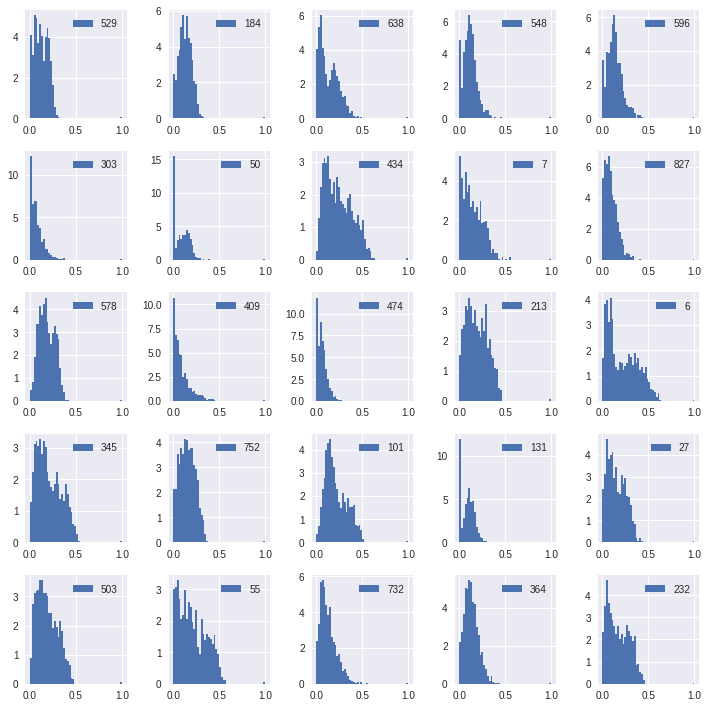

In [27]:
# pd.DataFrame(sim_user).head(10)
plt.figure(figsize=(10, 10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i, user in enumerate(np.random.choice(range(len(sim_user)), 25, replace=False)):
    plt.subplot(5, 5, i + 1)
    plt.hist(sim_user[user], 50, label=str(user), normed=True)
    plt.legend()

plt.tight_layout()

So for user-based collaborative filtering, instead of using all the weights from all the other users, we use the weights from top $k$ users with the highest similarity to the user of interest.


The graph belows show that the more users we have to compare similarity, the worse the scores.

In [385]:
# redefine the function to take in a param k (the number of user)
def predict(ratings, similarity, k = None):
    if k is None: k = similarity.shape[1]
#     if k > len(similarity): raise ValueError('K need to be smaller than', len(similarity))
    preds = np.zeros((len(similarity), ratings.shape[1])) # our predictions
    indexes = np.argsort(similarity)[:,::-1][:,1:k] # get indexes of similarity from large to small, only take the top k
    for i, index in enumerate(indexes):
        s = similarity[i, index]
        print(1, s.shape, s)
        r = ratings[index,:]
#         print(2, r.shape, r)
        tmp = s.dot(r)
        print(s, r, tmp, 'abs sum', np.abs(s).sum(), '\n')
        print(tmp / s.dot((r > 0)))
        tmp /= np.abs(s).sum() or 0 # sum may be 0
#         print(s)
        tmp = np.round(tmp, 0)
        preds[i] = tmp
    return preds

predict(train[:,:5], sim_user[[0, 1, 2]], 5)
# predict(train.T[:,:10], sim_item[[0, 1, 2]], 25)

1 (4,) [0.55754767 0.52629023 0.52439556 0.51929572]
[0.55754767 0.52629023 0.52439556 0.51929572] [[4. 3. 3. 4. 3.]
 [4. 3. 0. 4. 4.]
 [5. 4. 0. 4. 4.]
 [3. 2. 1. 4. 0.]] [8.51521655 6.38768737 2.19193874 8.51011672 5.87538615] abs sum 2.127529179976554 

[4.00239707 3.00239707 2.03552229 4.         3.65331671]
1 (4,) [0.48113944 0.46408819 0.44601785 0.42645937]
[0.48113944 0.46408819 0.44601785 0.42645937] [[2. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0.]
 [3. 0. 0. 0. 0.]] [2.24165699 0.         1.33805356 0.         0.        ] abs sum 1.8177048523915702 

[2.46987652        nan 3.                nan        nan]
1 (4,) [0.42899632 0.41959665 0.41573219 0.40232186]
[0.42899632 0.41959665 0.41573219 0.40232186] [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]] [0. 0. 0. 0. 0.] abs sum 1.6666470187196525 

[nan nan nan nan nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


array([[4., 3., 1., 4., 3.],
       [1., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0.]])

User based
Train set
Min rating: 0.0
Max rating: 5.0
Score: 0.4520

Test set
Min rating: 0.0
Max rating: 5.0
Score: 0.5821

Item based
Train set
Min rating: 0.0
Max rating: 5.0
Score: 0.4454

Test set
Min rating: 0.0
Max rating: 5.0
Score: 0.6331


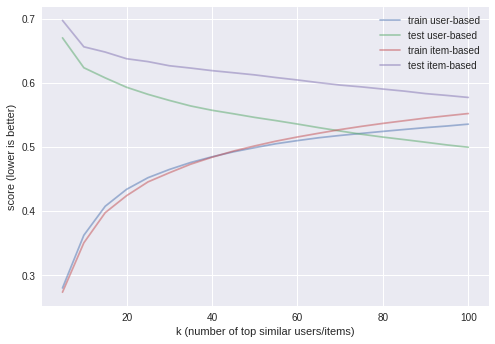

In [338]:
from sklearn.metrics import mean_squared_error as score

k = 25

# user based
tmp = predict(train, sim_user, k)
print(f'''User based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train, tmp):.4f}''')

# tmp = predict(test, sim_user, k)
print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test, tmp):.4f}''')


# # item based
tmp = predict(train.T, sim_item, k)
print(f'''
Item based
Train set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(train.T, tmp):.4f}''')

# tmp = predict(test.T, sim_item, k)
print(f'''
Test set
Min rating: {tmp.min()}
Max rating: {tmp.max()}
Score: {score(test.T, tmp):.4f}''')

ranges = range(5, 101, 5)
tmp = [predict(train, sim_user, i) for i in ranges]
plt.plot(ranges, [score(train, i) for i in tmp], '-', label='train user-based', alpha=0.5)
plt.plot(ranges, [score(test, i) for i in tmp], '-', label='test user-based', alpha=0.5)
                         
tmp = [predict(train.T, sim_item, i) for i in ranges]
plt.plot(ranges, [score(train.T, i) for i in tmp], '-', label='train item-based', alpha=0.5)
plt.plot(ranges, [score(test.T, i) for i in tmp], '-', label='test item-based', alpha=0.5)

plt.xlabel('k (number of top similar users/items)')
plt.ylabel('score (lower is better)')
plt.legend();